# Import libraries

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
from utils.helpers import *
from utils.mask_to_submission import *

import torch.utils.data as utils
import time
import torch
from torch import nn, optim
import torch.nn.functional as F
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # to plot images
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Preprocessing

## Load data

In [10]:
nb_imgs = 100
DATA_FOLDER = "DATA/"
TRAIN_FOLDER = DATA_FOLDER + 'training/'
IMAGE_FOLDER = TRAIN_FOLDER + 'images/'
GT_FOLDER = TRAIN_FOLDER + 'groundtruth/'

imgs, gt_imgs = load_images_and_grounds(IMAGE_FOLDER,GT_FOLDER,nb_imgs)
imgs[0].shape

(3, 400, 400)

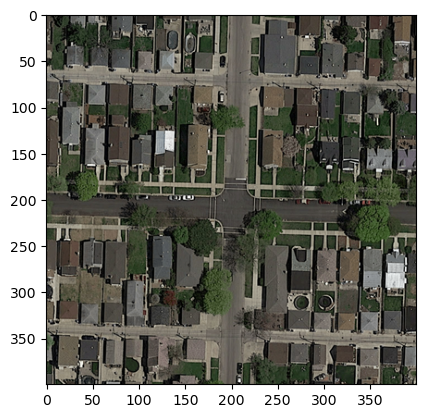

In [3]:
plt.imshow(imgs[0].swapaxes(0,2))

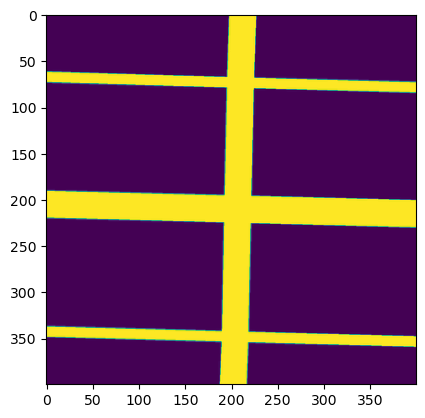

In [4]:
plt.imshow(gt_imgs[0].swapaxes(0,1))

## Transform data

No transformation yet

## Creation of datasets

In [11]:
ratio_train_val = 0.8 # 80% train, 20% validation
nb_train = int(128/ratio_train_val) # cropped images
w,h = 200,200
train_input, validation_input, train_target, validation_target = crop_images_train(ratio_train_val, imgs, gt_imgs,w,h,nb_train)

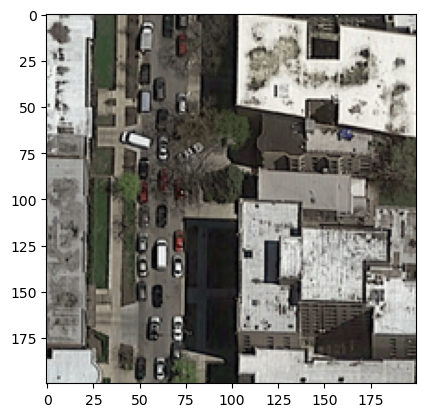

In [12]:
plt.imshow(train_input[0].swapaxes(0,2))

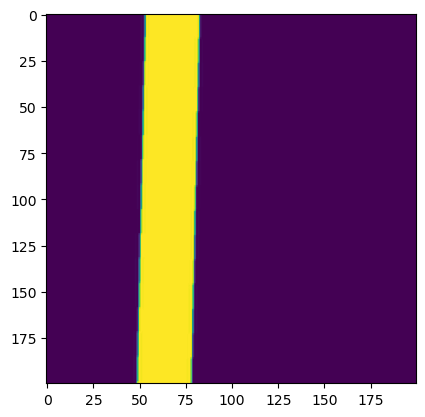

In [13]:
plt.imshow(train_target[0].swapaxes(0,1))

# Define the model

Model

In [15]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super().__init__()
        self.C1 = torch.nn.Conv2d(in_channels,out_channels,3,stride=stride,padding=1)
        self.C2 = torch.nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.N1 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.N2 = torch.nn.BatchNorm2d(num_features=out_channels)
        self.R1 = torch.nn.ReLU()
        self.R2 = torch.nn.ReLU()
        self.has_skip_conv = stride != 1 or in_channels != out_channels
        if self.has_skip_conv:
            self.C3 = torch.nn.Conv2d(in_channels, out_channels, 3,stride=stride, padding=1)
            self.N3 = torch.nn.BatchNorm2d(num_features=out_channels)

    def forward(self, x):
        if self.has_skip_conv:
            skip = self.N3(self.C3(x))
        else:
            skip = x
        residual = self.N2(self.C2(self.R1(self.N1(self.C1(x)))))
        x = self.R2(residual + skip)
        return x

def get_model(depth, base_width=16):
    block = ResidualBlock

    # Input layers
    modules = [
        torch.nn.Conv2d(3, base_width, 3, padding=1),
        torch.nn.BatchNorm2d(base_width),
        torch.nn.ReLU(),
    ]

    # Blocks and stages (based off the configuration used in the ResNet paper)
    blocks_per_stage = (depth - 2) // 6
    assert depth == blocks_per_stage * 6 + 2
    in_channels = base_width
    out_channels = base_width
    for stage_idx in range(3):
        for block_idx in range(blocks_per_stage):
            stride = 2 if block_idx == 0 and stage_idx > 0 else 1
            modules.append(
                block(
                    in_channels,
                    out_channels,
                    stride,
                )
            )
            in_channels = out_channels
        out_channels = out_channels * 2

    # Output layers
    modules.extend(
        [
            torch.nn.AdaptiveAvgPool2d((1,1)),
            torch.nn.Flatten(),
            torch.nn.Linear(in_channels,1),
            torch.nn.Sigmoid()
        ]
    )

    model = torch.nn.Sequential(*modules)
    print(f"Model:\n {model}")
    return model

Loss

In [16]:
class WeightedBCELoss(torch.nn.BCELoss):
    def __init__(self, class_weights=None):  # does not support weight, size_average, reduce, reduction
        super().__init__(reduction='none')
        if class_weights is None:
            class_weights = torch.ones(2)
        self.class_weights = torch.as_tensor(class_weights)

    def forward(self, input, target):
        raw_loss = super().forward(input, target)
        class_weights = self.class_weights.to(input.device)
        weight_matrix = class_weights[0]*(1-target) + class_weights[1]*target
        loss = weight_matrix * raw_loss
        loss = loss.mean()  # reduction='elementwise_mean'
        return loss

Training

In [33]:
save = True

batch_size = 64
batches_train = np.array([train_input[:batch_size*i] for i in range(1,int(len(train_input)/batch_size))])
batches_target = np.array([train_target[:batch_size*i] for i in range(1,int(len(train_input)/batch_size))])
batches_train = batches_train.reshape((-1,batch_size,3,w,h))
batches_target = batches_target.reshape((-1,batch_size,w,h))

nb_epochs = 10
model = get_model(20)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_function = torch.nn.BCELoss(reduction='mean')

loss_train_epoch =[]
loss_validation_epoch =[]
best_validation_loss = float("inf")
best_epoch = -1

#Time for printing
training_start_time = time.time()

#Loop for n_epochs
for epoch in range(nb_epochs):
    total_loss = 0.0
    
    for index in range(len(batches_train)):
        model.train()
        
        input_image = torch.tensor(batches_train[index]).to(device)
        target_image = torch.tensor(batches_target[index]).to(device)
        #Forward pass, backward pass, optimize
        outputs = model(input_image.float())
        target = np.array(list(map(patch_to_label,batches_target[index])))
        target = torch.tensor(target,dtype=torch.float).reshape(outputs.shape)
        loss = loss_function(outputs, target)

        #Set the parameter gradients to zero
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #Print statistics
        total_loss += loss.item() * input_image.size(0)

        print("Epoch", epoch, ", batch", index, ", batch loss:", loss.item(), ", time elapsed:", time.time() - training_start_time)

        #At the end of the epoch, do a pass on the validation set
        total_val_loss = 0
    for index in range(np.shape(validation_input)[0]):
        model.eval()

        input_image = torch.tensor(validation_input[index]).unsqueeze(0).to(device)
        target_image = torch.tensor(validation_target[index]).to(device)

        #Forward pass
        val_outputs = model(input_image.float())
        target = patch_to_label(np.asarray(target_image))
        target = torch.tensor(target,dtype=torch.float).reshape(val_outputs.shape)
        val_loss = loss_function(val_outputs, target)
        total_val_loss += val_loss.item() * input_image.size(0)

    print("Validation loss for epoch", epoch, ":", total_val_loss/np.shape(validation_input)[0])

    loss_train_epoch.append(total_loss/np.shape(train_input)[0])
    loss_validation_epoch.append(total_val_loss/np.shape(validation_input)[0])

    if(loss_validation_epoch[-1] < best_validation_loss):
        best_validation_loss = loss_validation_epoch[-1]
        best_epoch = epoch
        best_model = model
        if save:
            torch.save(model, 'results/best_model.pth')

print("Training finished, took {:.2f}s".format(time.time() - training_start_time))

if save:
    torch.save(model, 'results/last_model.pth')
    np.savetxt('results/losstrain.csv', loss_train_epoch, delimiter=',')
    np.savetxt('results/loss_validation.csv', loss_validation_epoch, delimiter=',')
    print('Results saved')

Model:
 Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): ResidualBlock(
    (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (C2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (N2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R1): ReLU()
    (R2): ReLU()
  )
  (4): ResidualBlock(
    (C1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (C2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (N1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (N2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (R1): ReLU()
    (R2): ReLU()
  )
  (5): ResidualBlock(
 

# Observe predictions

In [34]:
input_image = torch.tensor(train_input[1]).unsqueeze(0).to(device)
outputs = model(input_image.float())
print(outputs)

tensor([[0.3697]], grad_fn=<SigmoidBackward0>)


In [47]:
def pred_mask(model,img_test,w,h,s,batch=False):
    '''w,h = size crop; s = stride'''
    N = img_test.shape[1]
    tab = np.zeros((int((N-w)/s),int((N-h)/s)),dtype=float)
    res = np.zeros((N,N),dtype=float)
    if not batch:
        img_test = img_test.reshape(1,*img_test.shape)
    
    for m in range(tab.shape[0]):
        for n in range(tab.shape[1]):
            input_image = torch.tensor(img_test[:,:,m*s:m*s+w,n*s:n*s+h]).to(device)
            outputs = float(model(input_image.float()))
            tab[m,n] = outputs
    i_max = int((N-w)/s)
    j_max = int((N-h)/s)
    for i in range(N):
        i_end = int(i/s)
        if i < w:
            i_deb = 0
        elif i > i_max:
            i_end = i_max
        else:
            i_deb = int((i-w)/s)

        for j in range(N):
            j_end = int(j/s)
            if j < h:
                j_deb = 0
            elif j > j_max:
                j_end = j_max
            else:
                j_deb = int((j-h)/s)
            res[i,j] = tab[i_deb:i_end+1,j_deb:j_end+1].mean()

    return tab,res

In [ ]:
s = 5
tab,res = pred_mask(model,imgs[0],w,h,s)

Text(0.5, 1.0, 'Cropped predictions')

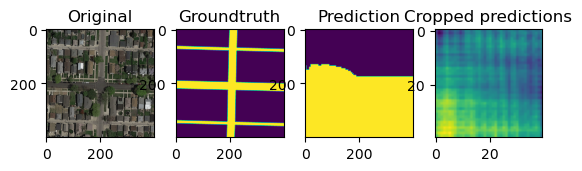

In [53]:
mean = res.mean()
output = res.copy()
t = 1
output[output < mean*t] = 0
output[output>=mean*t] = 1

fig,axs = plt.subplots(1,4)
axs[0].imshow(imgs[0].swapaxes(0,2))
axs[0].set_title('Original')
axs[1].imshow(gt_imgs[0].swapaxes(0,1))
axs[1].set_title('Groundtruth')
axs[2].imshow(output.swapaxes(0,1))
axs[2].set_title('Prediction')
axs[2].imshow(output.swapaxes(0,1))
axs[2].set_title('Prediction')
axs[3].imshow(tab.swapaxes(0,1))
axs[3].set_title('Cropped predictions')

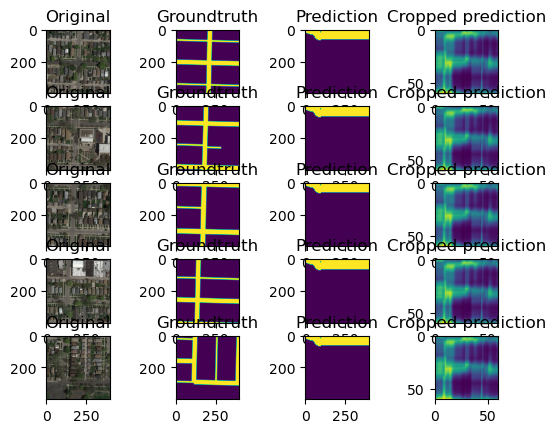

In [230]:
'''
s = 5
n=5
fig,axs = plt.subplots(n,4)
for i in range(n):
    tab,res = pred_mask(model,imgs[n],w,h,s)
    mean = res.mean()
    output = res.copy()
    t = 1.0398
    output[output < mean*t] = 0
    output[output>=mean*t] = 1
    
    axs[i,0].imshow(imgs[i].swapaxes(0,2))
    axs[i,0].set_title('Original')
    axs[i,1].imshow(gt_imgs[i].swapaxes(0,1))
    axs[i,1].set_title('Groundtruth')
    axs[i,2].imshow(output.swapaxes(0,1))
    axs[i,2].set_title('Prediction')
    axs[i,2].imshow(output.swapaxes(0,1))
    axs[i,2].set_title('Prediction')
    axs[i,3].imshow(tab.swapaxes(0,1))
    axs[i,3].set_title('Cropped prediction')
'''